In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import ttest_ind
from scipy import stats
from scipy.stats import mannwhitneyu
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

In [ ]:
# Replace 'otu_file' with the path to your TSV file
otu_file = 'otu_table_psn_v35.txt'
# wget http://downloads.hmpdacc.org/data/HMQCP/otu_table_psn_v35.txt.gz
# Read the TSV file while skipping the first line
otu_data = pd.read_csv(otu_file, sep='\t', skiprows=1)
# otu_data = pd.read_csv("path_to_your_output_file.csv")
otu_data.columns.values[0] = 'otu_id'

# Define a function to parse the taxonomic data
def parse_tax_data(otu_data, class_cols, class_regex, class_key, class_sep):
    # Extract class information based on class_cols and class_sep
    tax_data = otu_data[class_cols].str.split(class_sep, expand=True)
    
    # Create a DataFrame for taxonomic classification
    tax_data.columns = [f'{class_key["hmp_rank"]}_{i}' for i in range(tax_data.shape[1])]
    tax_data[class_key["hmp_tax"]] = tax_data.apply(lambda row: class_sep.join(row.dropna()), axis=1)
    
    # Merge taxonomic data back with the original OTU data
    otu_data = otu_data.drop(columns=[class_cols])
    otu_data = pd.concat([otu_data, tax_data], axis=1)
    
    return otu_data

# # Apply the function to parse taxonomic data
hmp_data = parse_tax_data(otu_data, "Consensus Lineage", r"([a-z]{0,1})_{0,2}(.*)$", {"hmp_rank": "taxon_rank", "hmp_tax": "taxon_name"}, ";")

# # Remove the regex match table (not needed in this case)
otu_data = hmp_data.drop(columns=[col for col in hmp_data.columns if col.startswith('taxon_rank_')])

# # Rename the abundance matrix to something more understandable
otu_data.columns = ['otu_count' if col == 'otu_id' else col for col in otu_data.columns]
# Select the top 1000 rows
# top_1000_hmp_data = hmp_data.head(5)


# Extract the suffix of 'g__' in the 'taxon_name' column
otu_data['genus'] = otu_data['taxon_name'].str.extract(r'g__([^;]*)')
otu_data = otu_data[otu_data['genus'].notna() & (otu_data['genus'] != '')]
# # Delete the 'taxon_name' column
otu_data = otu_data.drop(columns=['taxon_name'])
# # Group by 'genus' and accumulate the OTU counts
# if 'genus' in otu_data.columns:
#     otu_data = otu_data.groupby('genus').sum().reset_index()
# else:
#     otu_data = otu_data  # If there is no 'genus' column, use the original data

# # Print the filtered DataFrame
# print(otu_data.head(5))
# otu_data = otu_data.drop(columns=['otu_count'])
num_rows, num_columns = otu_data.shape
# print(f'The DataFrame has {num_rows} rows and {num_columns} columns.')
# Rotate the DataFrame 90 degrees clockwise
otu_data = otu_data.transpose()

# Make the first row the header
otu_data.columns = otu_data.iloc[0]
otu_data = otu_data[1:]
otu_data.to_csv("genus_rotated.csv", index=False)
# Define the path for the output CSV file
# csv_file = 'path_to_your_output_file.csv'

# # Convert the DataFrame to a CSV file
# top_1000_hmp_data.to_csv(csv_file, index=False)


In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# Load the OTU table file
otu_table = pd.read_csv('genus_rotated_f.csv', header=0, index_col=None)
# Drop columns if all their values are 0
otu_table = otu_table.loc[:, (otu_table != 0).any(axis=0)]
# otu_table
# # Normalize the OTU counts (skip the first column if it's the sample IDs)
otu_table_proportions = otu_table.div(otu_table.sum(axis=1), axis=0)
print(otu_table_proportions)
# # Convert proportions to percentages
otu_table_percentages = otu_table_proportions*100
# print(genus_to_idx.head(5))
# # Save the normalized data to a CSV file
# otu_table_percentages.to_csv('otu_table_percentages.csv', index=False)
# # Create a dictionary to map genus names to unique indices
genus_names = otu_table_proportions.columns.tolist()
genus_to_idx = {genus: idx for idx, genus in enumerate(genus_names)}
class OTUDataset(Dataset):
    def __init__(self, data, genus_to_idx):
        self.data = data
        self.genus_to_idx = genus_to_idx
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        counts = self.data.iloc[idx].tolist()
        # print(counts)
        input_ids = [self.genus_to_idx[genus] for genus in self.genus_to_idx]
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'labels': torch.tensor(counts, dtype=torch.float)
        }

# Create a dataset and dataloader
dataset = OTUDataset(otu_table_proportions, genus_to_idx)
# print(dataset)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

     Abiotrophia  Acidaminococcus  Actinobacillus  Actinomyces  Adlercreutzia   
0            0.0         0.000000         0.00000     0.000000       0.000229  \
1            0.0         0.000000         0.00000     0.000000       0.000000   
2            0.0         0.006494         0.00000     0.000000       0.000000   
3            0.0         0.000000         0.00000     0.000000       0.000427   
4            0.0         0.000000         0.00028     0.000000       0.000000   
..           ...              ...             ...          ...            ...   
314          0.0         0.000000         0.00000     0.000000       0.000000   
315          0.0         0.000000         0.00000     0.000000       0.000000   
316          0.0         0.000000         0.00000     0.000257       0.000000   
317          0.0         0.000000         0.00000     0.000000       0.000000   
318          0.0         0.000000         0.00000     0.000554       0.000000   

     Aggregatibacter  Akker

In [3]:
import time
import matplotlib.pyplot as plt
# Define the transformer model
class SimpleTransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length):
        super(SimpleTransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = nn.Embedding(max_seq_length, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.regressor = nn.Linear(d_model, vocab_size)
        
    def forward(self, src, labels=None):
        src = self.embedding(src) + self.pos_encoder(torch.arange(src.size(1), device=src.device).unsqueeze(0).repeat(src.size(0), 1))
        output = self.transformer_encoder(src)
        output = output[:, 0, :]  # Use the first token representation for regression
        logits = self.regressor(output)
        
        loss = None
        if labels is not None:
            loss = nn.MSELoss()(logits, labels)
        
        return loss, logits
# Define the model parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(genus_to_idx)
d_model = 256
nhead = 4
num_encoder_layers = 4
dim_feedforward = 512#512
max_seq_length = len(genus_to_idx)
model = SimpleTransformerModel(vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length).to(device)

# Training loop
optimizer = Adam(model.parameters(), lr=1e-7)
num_epochs = 128
start_time = time.time()
loss_values = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        loss, _ = model(input_ids, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    loss_values.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f'Training Time: {training_time:.2f} seconds')

# Save the model
torch.save(model.state_dict(), 'simple_transformer_model.pth')
# Plotting the loss function figure
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1, max(1, num_epochs // 10)))  # Adjust x-ticks for better readability
plt.show()

Epoch 1/128, Loss: 0.3203
Epoch 2/128, Loss: 0.3087
Epoch 3/128, Loss: 0.2988
Epoch 4/128, Loss: 0.2912
Epoch 5/128, Loss: 0.2836
Epoch 6/128, Loss: 0.2729
Epoch 7/128, Loss: 0.2639
Epoch 8/128, Loss: 0.2575
Epoch 9/128, Loss: 0.2502
Epoch 10/128, Loss: 0.2401
Epoch 11/128, Loss: 0.2355
Epoch 12/128, Loss: 0.2263
Epoch 13/128, Loss: 0.2193
Epoch 14/128, Loss: 0.2130
Epoch 15/128, Loss: 0.2062
Epoch 16/128, Loss: 0.1994
Epoch 17/128, Loss: 0.1926
Epoch 18/128, Loss: 0.1870
Epoch 19/128, Loss: 0.1804
Epoch 20/128, Loss: 0.1752
Epoch 21/128, Loss: 0.1691
Epoch 22/128, Loss: 0.1629
Epoch 23/128, Loss: 0.1574
Epoch 24/128, Loss: 0.1540
Epoch 25/128, Loss: 0.1474
Epoch 26/128, Loss: 0.1420
Epoch 27/128, Loss: 0.1393
Epoch 28/128, Loss: 0.1330
Epoch 29/128, Loss: 0.1298
Epoch 30/128, Loss: 0.1239
Epoch 31/128, Loss: 0.1215
Epoch 32/128, Loss: 0.1172
Epoch 33/128, Loss: 0.1136
Epoch 34/128, Loss: 0.1098
Epoch 35/128, Loss: 0.1053


KeyboardInterrupt: 

In [8]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import random

# Load the OTU table file
otu_table = pd.read_csv('genus_rotated_f.csv', header=0, index_col=None)
# Drop columns if all their values are 0
otu_table = otu_table.loc[:, (otu_table != 0).any(axis=0)]
# Normalize the OTU counts (skip the first column if it's the sample IDs)
otu_table_proportions = otu_table.div(otu_table.sum(axis=1), axis=0)
otu_table_percentages = otu_table_proportions * 100

# Create a dictionary to map genus names to unique indices
genus_names = otu_table_proportions.columns.tolist()
genus_to_idx = {genus: idx for idx, genus in enumerate(genus_names)}
idx_to_genus = {idx: genus for genus, idx in genus_to_idx.items()}
mask_token_idx = len(genus_to_idx)  # Assign the next index for the <MASK> token
genus_to_idx['<MASK>'] = mask_token_idx

class OTUDataset(Dataset):
    def __init__(self, data, genus_to_idx, mask_prob=0.1):
        self.data = data
        self.genus_to_idx = genus_to_idx
        self.mask_prob = mask_prob
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        counts = self.data.iloc[idx].tolist()
        input_ids = [self.genus_to_idx[genus] for genus in self.data.columns]
        
        # Apply masking
        masked_input_ids = input_ids.copy()
        for i in range(len(masked_input_ids)):
            if random.random() < self.mask_prob:
                masked_input_ids[i] = self.genus_to_idx['<MASK>']
        
        return {
            'input_ids': torch.tensor(masked_input_ids, dtype=torch.long),
            'labels': torch.tensor(counts, dtype=torch.float)
        }

# Create a dataset and dataloader
dataset = OTUDataset(otu_table_proportions, genus_to_idx, mask_prob=0.15)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

genus_to_idx


{'Abiotrophia': 0,
 'Acidaminococcus': 1,
 'Actinobacillus': 2,
 'Actinomyces': 3,
 'Adlercreutzia': 4,
 'Aggregatibacter': 5,
 'Akkermansia': 6,
 'Alistipes': 7,
 'Allobaculum': 8,
 'Anaerococcus': 9,
 'Anaerofilum': 10,
 'Anaerofustis': 11,
 'Anaerostipes': 12,
 'Anaerotruncus': 13,
 'Anaerovorax': 14,
 'Asteroleplasma': 15,
 'Atopobium': 16,
 'Bacillus': 17,
 'Bacteroides': 18,
 'Bifidobacterium': 19,
 'Bilophila': 20,
 'Blautia': 21,
 'Brachymonas': 22,
 'Brachyspira': 23,
 'Bulleidia': 24,
 'Campylobacter': 25,
 'Capnocytophaga': 26,
 'Catenibacterium': 27,
 'Citrobacter': 28,
 'Cloacibacillus': 29,
 'Clostridium': 30,
 'Collinsella': 31,
 'Comamonas': 32,
 'Coprobacillus': 33,
 'Coprococcus': 34,
 'Corynebacterium': 35,
 'Dehalobacterium': 36,
 'Desulfovibrio': 37,
 'Dialister': 38,
 'Dorea': 39,
 'Dysgonomonas': 40,
 'Eggerthella': 41,
 'Enterococcus': 42,
 'Escherichia': 43,
 'Eubacterium': 44,
 'Faecalibacterium': 45,
 'Finegoldia': 46,
 'Fusobacterium': 47,
 'Gardnerella': 48

Epoch 1/128, Loss: 0.3017
Epoch 2/128, Loss: 0.2961
Epoch 3/128, Loss: 0.2885
Epoch 4/128, Loss: 0.2794
Epoch 5/128, Loss: 0.2729
Epoch 6/128, Loss: 0.2662
Epoch 7/128, Loss: 0.2571
Epoch 8/128, Loss: 0.2506
Epoch 9/128, Loss: 0.2438
Epoch 10/128, Loss: 0.2368
Epoch 11/128, Loss: 0.2312
Epoch 12/128, Loss: 0.2258
Epoch 13/128, Loss: 0.2181
Epoch 14/128, Loss: 0.2120
Epoch 15/128, Loss: 0.2064
Epoch 16/128, Loss: 0.1999
Epoch 17/128, Loss: 0.1961
Epoch 18/128, Loss: 0.1893
Epoch 19/128, Loss: 0.1857
Epoch 20/128, Loss: 0.1768
Epoch 21/128, Loss: 0.1777
Epoch 22/128, Loss: 0.1701
Epoch 23/128, Loss: 0.1627
Epoch 24/128, Loss: 0.1580
Epoch 25/128, Loss: 0.1547
Epoch 26/128, Loss: 0.1488
Epoch 27/128, Loss: 0.1460
Epoch 28/128, Loss: 0.1421
Epoch 29/128, Loss: 0.1381
Epoch 30/128, Loss: 0.1351
Epoch 31/128, Loss: 0.1292
Epoch 32/128, Loss: 0.1249
Epoch 33/128, Loss: 0.1219
Epoch 34/128, Loss: 0.1182
Epoch 35/128, Loss: 0.1161
Epoch 36/128, Loss: 0.1127
Epoch 37/128, Loss: 0.1110
Epoch 38/1

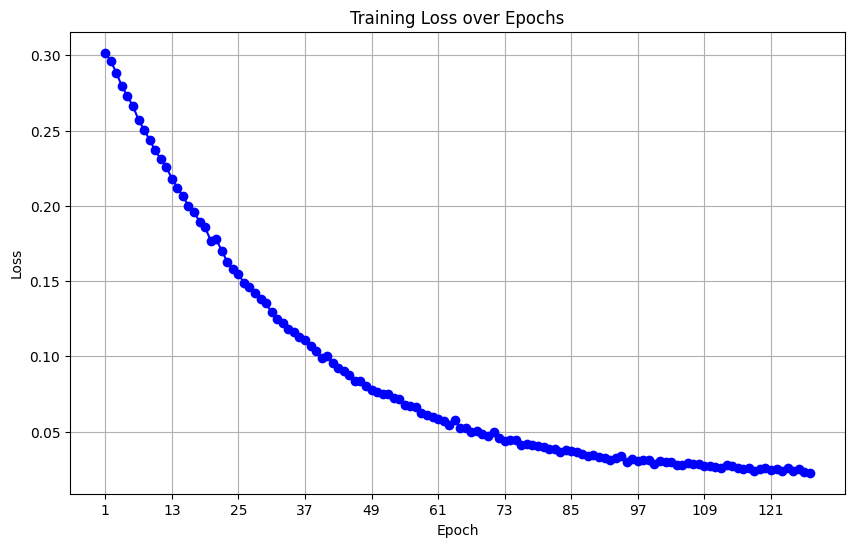

In [9]:
class SimpleTransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length):
        super(SimpleTransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = nn.Embedding(max_seq_length, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.regressor = nn.Linear(d_model, len(genus_to_idx) - 1)  # Regress to original OTU dimensions
        
    def forward(self, src, labels=None):
        # Ensure the positional encoding matches the sequence length of src
        positions = torch.arange(0, src.size(1), device=src.device).unsqueeze(0).repeat(src.size(0), 1)
        src = self.embedding(src) + self.pos_encoder(positions)
        output = self.transformer_encoder(src)
        output = output[:, 0, :]  # Use the first token representation for regression
        logits = self.regressor(output)
        
        loss = None
        if labels is not None:
            loss = nn.MSELoss()(logits, labels)
        
        return loss, logits

# Define the model parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(genus_to_idx) + 1  # Add 1 for the <MASK> token
d_model = 256
nhead = 4
num_encoder_layers = 4
dim_feedforward = 512
max_seq_length = len(genus_to_idx)  # Number of unique genera
model = SimpleTransformerModel(vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length).to(device)

# Training loop
optimizer = Adam(model.parameters(), lr=1e-7)
num_epochs = 128
start_time = time.time()
loss_values = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        loss, _ = model(input_ids, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    loss_values.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f'Training Time: {training_time:.2f} seconds')

# Save the model
torch.save(model.state_dict(), 'simple_transformer_model.pth')

# Plotting the loss function figure
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1, max(1, num_epochs // 10)))  # Adjust x-ticks for better readability
plt.show()

In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
0
NVIDIA GeForce RTX 3060


Epoch 1/128, Loss: 0.9002
Epoch 2/128, Loss: 0.7931
Epoch 3/128, Loss: 0.7010
Epoch 4/128, Loss: 0.6262
Epoch 5/128, Loss: 0.5600
Epoch 6/128, Loss: 0.5033
Epoch 7/128, Loss: 0.4556
Epoch 8/128, Loss: 0.4203
Epoch 9/128, Loss: 0.3901
Epoch 10/128, Loss: 0.3670
Epoch 11/128, Loss: 0.3428
Epoch 12/128, Loss: 0.3287
Epoch 13/128, Loss: 0.3137
Epoch 14/128, Loss: 0.3037
Epoch 15/128, Loss: 0.2923
Epoch 16/128, Loss: 0.2849
Epoch 17/128, Loss: 0.2757
Epoch 18/128, Loss: 0.2700
Epoch 19/128, Loss: 0.2648
Epoch 20/128, Loss: 0.2604
Epoch 21/128, Loss: 0.2586
Epoch 22/128, Loss: 0.2548
Epoch 23/128, Loss: 0.2541
Epoch 24/128, Loss: 0.2502
Epoch 25/128, Loss: 0.2477
Epoch 26/128, Loss: 0.2456
Epoch 27/128, Loss: 0.2439
Epoch 28/128, Loss: 0.2436
Epoch 29/128, Loss: 0.2417
Epoch 30/128, Loss: 0.2402
Epoch 31/128, Loss: 0.2387
Epoch 32/128, Loss: 0.2398
Epoch 33/128, Loss: 0.2378
Epoch 34/128, Loss: 0.2383
Epoch 35/128, Loss: 0.2358
Epoch 36/128, Loss: 0.2359
Epoch 37/128, Loss: 0.2363
Epoch 38/1

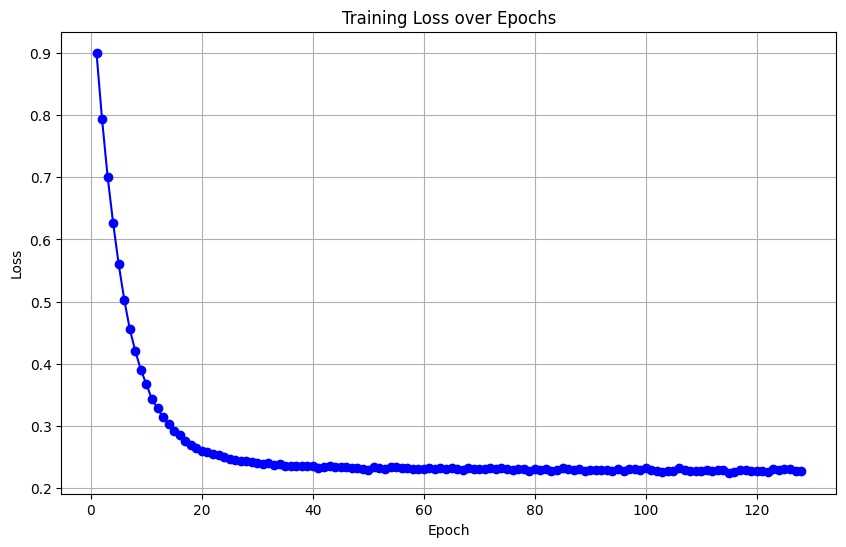

In [17]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

# Load the OTU table file
otu_table = pd.read_csv('genus_rotated_f.csv', header=0, index_col=None)
# Drop columns if all their values are 0
otu_table = otu_table.loc[:, (otu_table != 0).any(axis=0)]
# Normalize the OTU counts (skip the first column if it's the sample IDs)
otu_table_proportions = otu_table.div(otu_table.sum(axis=1), axis=0)
# Convert proportions to percentages
otu_table_percentages = otu_table_proportions * 100
# Create a dictionary to map genus names to unique indices
genus_names = otu_table_proportions.columns.tolist()
genus_to_idx = {genus: idx for idx, genus in enumerate(genus_names)}

class OTUDataset(Dataset):
    def __init__(self, data, genus_to_idx, mask_prob=0.30):
        self.data = data
        self.genus_to_idx = genus_to_idx
        self.mask_prob = mask_prob

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        counts = self.data.iloc[idx].tolist()
        input_ids = [self.genus_to_idx[genus] for genus in self.genus_to_idx]
        masked_ids, masked_labels = self.random_mask(counts)
        
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'labels': torch.tensor(counts, dtype=torch.float),
            'masked_labels': torch.tensor(masked_labels, dtype=torch.float)
        }
    
    def random_mask(self, counts):
        masked_labels = []
        for i in range(len(counts)):
            if np.random.rand() < self.mask_prob:
                masked_labels.append(counts[i])
                counts[i] = -1  # Masking this value
            else:
                masked_labels.append(-1)  # Not a target for prediction
        return counts, masked_labels

# Define the transformer model
class SimpleTransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length):
        super(SimpleTransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = nn.Embedding(max_seq_length, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.regressor = nn.Linear(d_model, vocab_size)
    
    def forward(self, src, masked_labels):
        src = self.embedding(src) + self.pos_encoder(torch.arange(src.size(1), device=src.device).unsqueeze(0).repeat(src.size(0), 1))
        output = self.transformer_encoder(src)
        output = output[:, 0, :]  # Use the first token representation for regression
        logits = self.regressor(output)
        
        loss = nn.MSELoss()(logits, masked_labels)
        
        return loss, logits

# Setup and training configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(genus_to_idx)
d_model = 256
nhead = 4
num_encoder_layers = 4
dim_feedforward = 512
max_seq_length = len(genus_to_idx)
model = SimpleTransformerModel(vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length).to(device)
optimizer = Adam(model.parameters(), lr=1e-6)
num_epochs = 128

# Training loop with masked training
dataset = OTUDataset(otu_table_proportions, genus_to_idx)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
loss_values = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        masked_labels = batch['masked_labels'].to(device)
        
        optimizer.zero_grad()
        loss, _ = model(input_ids, masked_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    loss_values.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
